In [16]:
base_dir = "/Users/arnavbhatnagar/Downloads/v_2"
categories = ['agri', 'barrenland', 'grassland', 'urban']

In [17]:
from PIL import Image
import os
import numpy as np

# Load and normalize color images
image_path_col = '/Users/arnavbhatnagar/Downloads/v_2/agri/s2'
color_images_files = [f for f in os.listdir(image_path_col) if f.endswith('.jpg') or f.endswith('.png')]
color_images = [Image.open(os.path.join(image_path_col, img_file)).convert("RGB") for img_file in color_images_files]
color_images = np.array([np.array(img) / 255.0 for img in color_images])  # Normalize to [0, 1]

# Load and normalize grayscale images
image_path_gray = '/Users/arnavbhatnagar/Downloads/v_2/agri/s1'
gray_images_file = [f for f in os.listdir(image_path_gray) if f.endswith('.jpg') or f.endswith('.png')]
gray_images = [Image.open(os.path.join(image_path_gray, img_file)).convert("L") for img_file in gray_images_file]
gray_images = np.array([np.array(img) / 255.0 for img in gray_images])  # Normalize to [0, 1]

In [18]:
import cv2
# Target size for resizing
target_size = (224, 224)  # New dimensions (width, height)

# Resize all images 
gray_images= np.array([cv2.resize(img, target_size) for img in gray_images])
color_images = np.array([cv2.resize(img,target_size) for img in color_images])
#converting 2d array to 3d array
gray_images = np.expand_dims(gray_images, axis=-1)


print(gray_images.shape)  # Output: (4000, 128, 128, 1)
print(color_images.shape)

(4000, 224, 224, 1)
(4000, 224, 224, 3)


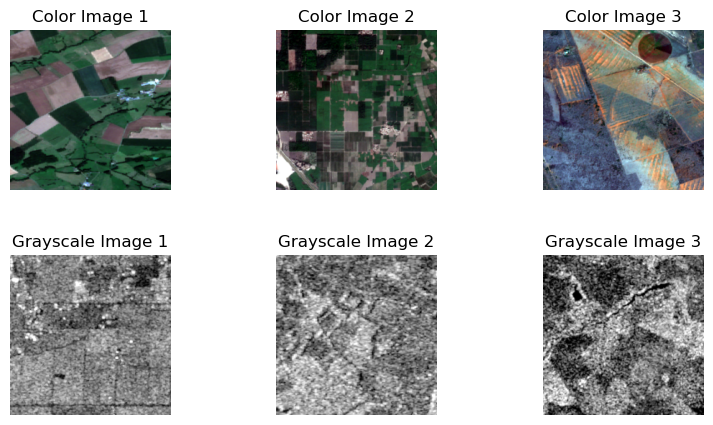

In [19]:
import matplotlib.pyplot as plt

n_samples = 3  # Number of images to display

# Set up the figure size to make the plots clearer
plt.figure(figsize=(10, 5))

# Plot color images in the first row
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.axis('off')
    plt.imshow(color_images[i])
    plt.title(f"Color Image {i+1}")  # Adding title

# Plot grayscale images in the second row
for i in range(n_samples):
    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.axis('off')
    plt.imshow(gray_images[i], cmap='gray')  # Ensure grayscale images are shown correctly
    plt.title(f"Grayscale Image {i+1}")  # Adding title

# Adjust spacing between subplots to avoid overlap
plt.subplots_adjust(wspace=0.1, hspace=0.4)

# Display the plot
plt.show()


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [21]:
data = [gray_images, color_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [22]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model

def build_generator(image_shape):
    input_layer = Input(shape=image_shape)  # Input shape (height, width, channels)

    # Encoder
    e1 = Conv2D(64, (3, 3), padding='same')(input_layer)
    e1 = BatchNormalization()(e1)
    e1 = LeakyReLU(alpha=0.2)(e1)
    e1_pool = MaxPooling2D(pool_size=(2, 2))(e1)
    
    e2 = Conv2D(128, (3, 3), padding='same')(e1_pool)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(alpha=0.2)(e2)
    e2_pool = MaxPooling2D(pool_size=(2, 2))(e2)

    e3 = Conv2D(256, (3, 3), padding='same')(e2_pool)
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(alpha=0.2)(e3)
    e3_pool = MaxPooling2D(pool_size=(2, 2))(e3)

    # Decoder
    d1 = Conv2DTranspose(256, (3, 3), padding='same', strides=(2, 2))(e3_pool)
    d1 = BatchNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = concatenate([d1, e3])

    d2 = Conv2DTranspose(128, (3, 3), padding='same', strides=(2, 2))(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)
    d2 = concatenate([d2, e2])

    d3 = Conv2DTranspose(64, (3, 3), padding='same', strides=(2, 2))(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    d3 = concatenate([d3, e1])

    # Final convolution to restore original dimensions
    output_layer = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(d3)  # Output color image

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [23]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model

def build_discriminator(image_shape):
    input_layer = Input(shape=image_shape)

    # First convolutional block
    x = Conv2D(64, (3, 3), strides=2, padding='same')(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    # Second convolutional block
    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    # Third convolutional block
    x = Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    # Fourth convolutional block (optional, for deeper network)
    x = Conv2D(512, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    # Flatten and Dense output
    x = Flatten()(x)
    output_layer = Dense(1, activation='sigmoid')(x)  # Output probability of being real

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [24]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, Lambda
import tensorflow as tf

def build_perceptual_model():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    vgg.trainable = False  # Make VGG19 non-trainable

    # Extract features from a specific layer, e.g., 'block5_conv4'
    perceptual_layer = vgg.get_layer('block5_conv4').output

    return Model(inputs=vgg.input, outputs=perceptual_layer)

def build_gan(generator, discriminator):
    # Freeze the discriminator during GAN training
    discriminator.trainable = False

    # Define the perceptual model
    perceptual_model = build_perceptual_model()

    # Input layer for GAN
    input_layer = Input(shape=(224, 224, 1))  # Grayscale input

    # Generate an image using the generator
    generated_image = generator(input_layer)

    # Convert grayscale to RGB to match VGG input within a Lambda layer
    generated_image_rgb = Lambda(
        lambda x: tf.image.grayscale_to_rgb(x),
        output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 3)
    )(generated_image)

    # Get perceptual features using the VGG19 model
    perceptual_features = perceptual_model(generated_image_rgb)

    # Discriminator output
    validity = discriminator(generated_image_rgb)

    # GAN Model
    model = Model(inputs=input_layer, outputs=[generated_image, validity, perceptual_features])

    return model

# Define image shape
image_shape = (224, 224, 1)  # Grayscale images

# Build models
generator = build_generator(image_shape)
discriminator = build_discriminator((224, 224, 3))  # Color images
gan = build_gan(generator, discriminator)

# Compile models
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)


/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [25]:
# Define image shape
image_shape = (224, 224, 1)  # Grayscale images

# Build models
generator = build_generator(image_shape)
discriminator = build_discriminator((224, 224, 3))  # Color images
gan = build_gan(generator, discriminator)

# Compile models
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [26]:
def train_gan(gan, generator, discriminator, epochs, batch_size, grayscale_images, color_images, sample_interval=100, save_model_interval=500, save_path='./gan_model'):
    for epoch in range(epochs):
        # Select a random batch of images
        idx = np.random.randint(0, grayscale_images.shape[0], batch_size)
        grayscale_batch = grayscale_images[idx]
        color_batch = color_images[idx]

        # Generate fake color images
        generated_images = generator.predict(grayscale_batch)

        # Create labels for real and fake images
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(color_batch, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        g_loss = gan.train_on_batch(grayscale_batch, [color_batch, real_labels])

        # Print the progress every `sample_interval` epochs
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss[0]:.4f}]")

        # Save the model at regular intervals
        if epoch % save_model_interval == 0 and epoch != 0:
            gan.save(f"{save_path}_epoch_{epoch}.h5")
            print(f"Model saved at epoch {epoch}")



In [27]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator during GAN training

    input_layer = Input(shape=(224, 224, 1))  # Grayscale input
    generated_image = generator(input_layer)

    # Check the shape of the generated image
    print("Generated image shape:", generated_image.shape)

    # Ensure the generated image is grayscale (i.e., has shape (batch_size, height, width, 1))
    if generated_image.shape[-1] != 1:
        raise ValueError("The generator output should have a last dimension size of 1 (grayscale).")

    # Convert grayscale to RGB to match VGG input within a Lambda layer
    generated_image_rgb = Lambda(
        lambda x: tf.image.grayscale_to_rgb(x),
        output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 3)
    )(generated_image)

    # Get perceptual features using the VGG19 model
    perceptual_features = perceptual_model(generated_image_rgb)

    # GAN Model
    model = Model(inputs=input_layer, outputs=[generated_image, discriminator(generated_image), perceptual_features])
    
    return model


In [28]:
import numpy as np
from skimage.metrics import mean_squared_error, structural_similarity as ssim

def calculate_metrics(generator, grayscale_images, color_images):
    # Generate color images from the grayscale input
    generated_images = generator.predict(grayscale_images)
    
    mse_values = []
    ssim_values = []
    
    for i in range(len(generated_images)):
        original = color_images[i]
        generated = generated_images[i]
        
        # Compute MSE between the generated and original color images
        mse = mean_squared_error(original, generated)
        mse_values.append(mse)
        
        # Compute SSIM between the generated and original color images
        ssim_value = ssim(original, generated, win_size=3, data_range=1.0, channel_axis=-1)
        ssim_values.append(ssim_value)
    
    avg_mse = np.mean(mse_values)
    avg_ssim = np.mean(ssim_values)
    
    return avg_mse, avg_ssim

# Example usage:
# Assuming `generator` is your trained generator model,
# and `gray_images` and `color_images` are your datasets.

avg_mse, avg_ssim = calculate_metrics(generator, gray_images[:100], color_images[:100])

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Average MSE: 0.0712
Average SSIM: 0.3979


In [ ]:
#try

In [29]:
def calculate_metrics(generator, grayscale_images, color_images):
    generated_images = generator.predict(grayscale_images)
    
    mse_values = []
    ssim_values = []
    
    for i in range(len(generated_images)):
        original = color_images[i]
        generated = generated_images[i]
        
        mse = mean_squared_error(original, generated)
        mse_values.append(mse)
        
        ssim_value = ssim(original, generated, win_size=3, data_range=1.0, channel_axis=-1)
        ssim_values.append(ssim_value)
    
    avg_mse = np.mean(mse_values)
    avg_ssim = np.mean(ssim_values)
    
    return avg_mse, avg_ssim

avg_mse, avg_ssim = calculate_metrics(generator, gray_images[:100], color_images[:100])

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Average MSE: 0.0712
Average SSIM: 0.3979


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Colorized image shape for sample 1: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Colorized image shape for sample 2: (224, 224, 3)


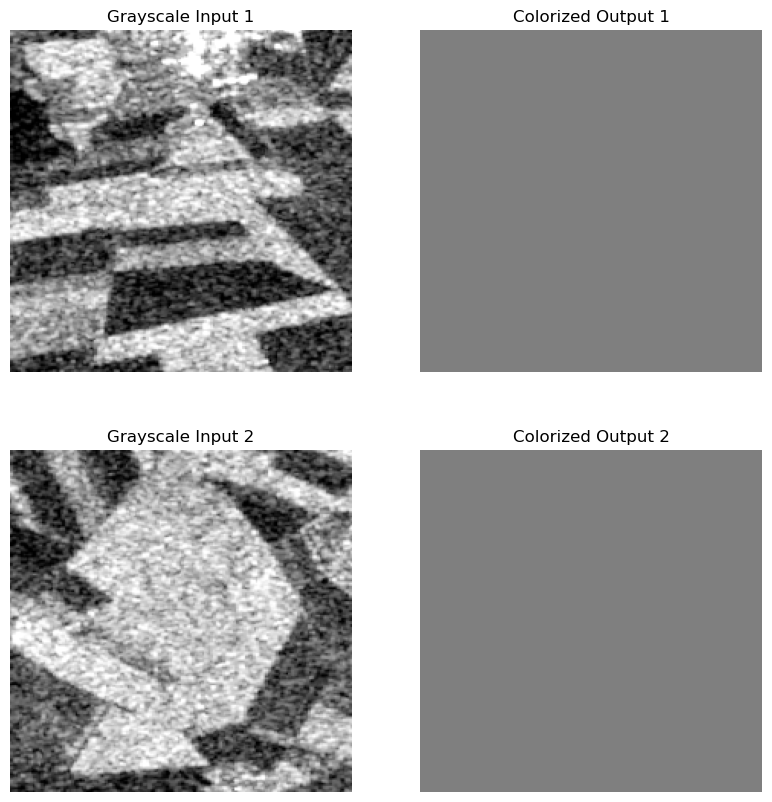

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_grayscale_image(grayscale_image, target_size):
    # Normalize grayscale image to [0, 1] and add batch dimension
    grayscale_image = cv2.resize(grayscale_image, target_size)  # Resize to match input size
    grayscale_image = grayscale_image / 255.0  # Normalize to [0, 1]
    grayscale_image = np.expand_dims(grayscale_image, axis=-1)  # Add channel dimension
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  # Add batch dimension
    return grayscale_image

def visualize_predictions(generator, grayscale_images, target_size, num_samples=2):
    # Ensure the number of samples does not exceed the available images
    num_samples = min(num_samples, len(grayscale_images))
    
    # Prepare a figure with appropriate size for displaying multiple images
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get grayscale image and preprocess
        grayscale_image = grayscale_images[i]
        preprocessed_image = preprocess_grayscale_image(grayscale_image, target_size)
        
        # Display grayscale input image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(grayscale_image.squeeze(), cmap='gray')
        plt.title(f'Grayscale Input {i + 1}')
        plt.axis('off')
        
        # Generate colorized image
        try:
            colorized_image = generator.predict(preprocessed_image)
            colorized_image = np.squeeze(colorized_image, axis=0)  # Remove batch dimension
            
            # Ensure values are in the range [0, 1] for display
            colorized_image = np.clip(colorized_image, 0, 1)
            
            # Check shape of the colorized image
            print(f"Colorized image shape for sample {i + 1}: {colorized_image.shape}")
            
            # Debugging: check if the image is blank
            if np.all(colorized_image == 0):
                print(f"Warning: Colorized image for sample {i + 1} is blank.")
            
        except Exception as e:
            print(f"Error during prediction for sample {i + 1}: {e}")
            colorized_image = np.zeros((target_size[0], target_size[1], 3))  # Placeholder for error
        
        # Display predicted color image
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(colorized_image)
        plt.title(f'Colorized Output {i + 1}')
        plt.axis('off')
    
    # Display the plot
    plt.show()

# Test with multiple images from your dataset
num_samples = 2  # Number of images to test
target_size = (224, 224)  # Adjust to match the model's input size
sample_indices = np.random.choice(len(gray_images), num_samples, replace=False)  # Randomly select sample indices
selected_grayscale_images = [gray_images[idx] for idx in sample_indices]

visualize_predictions(generator, selected_grayscale_images, target_size, num_samples=num_samples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


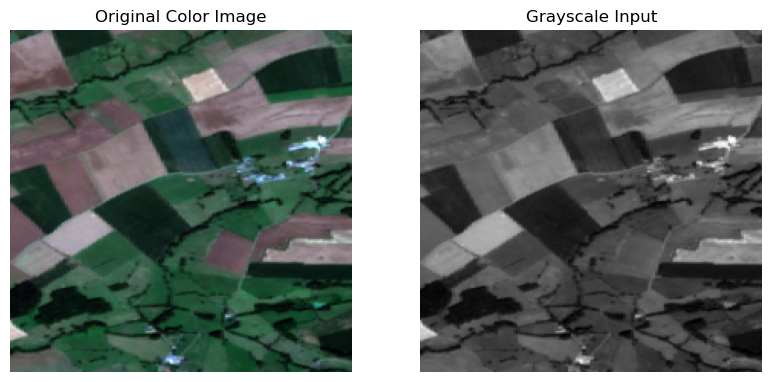

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_single_prediction(generator, original_color_image):
    # Convert the original color image to uint8 type
    original_color_image = (original_color_image * 255).astype(np.uint8)
    
    # Convert the original color image to grayscale
    grayscale_image = cv2.cvtColor(original_color_image, cv2.COLOR_RGB2GRAY)
    grayscale_image = cv2.resize(grayscale_image, (224, 224))  # Resize to match input size
    grayscale_image = grayscale_image / 255.0  # Normalize to [0, 1]
    grayscale_image = np.expand_dims(grayscale_image, axis=-1)  # Add channel dimension
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  # Add batch dimension

    # Generate colorized image
    colorized_image = generator.predict(grayscale_image)
    colorized_image = np.squeeze(colorized_image, axis=0)  # Remove batch dimension
    colorized_image = np.clip(colorized_image, 0, 1)  # Ensure values are in the range [0, 1]

    # Display the images
    plt.figure(figsize=(15, 5))

    # Original color image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.resize(original_color_image, (224, 224)))
    plt.title('Original Color Image')
    plt.axis('off')

    # Grayscale image
    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_image.squeeze(), cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')

# Test with a single image from your dataset
sample_index = 0  # You can change this to test with different images
original_image = color_images[sample_index]  # Use one of your color images

visualize_single_prediction(generator, original_image)